In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal
import numpy as np
import rasterio
import cv2

In [2]:
path_sentinel = Path(r'SENTINEL\L1C_T18SUH_A020529_20210209T155442\S2B_MSIL1C_20210209T155309_N0209_R054_T18SUH_20210209T193948.SAFE\GRANULE\L1C_T18SUH_A020529_20210209T155442\IMG_DATA')
# Se guarda la ruta de las imágenes con extensión jp2
sentinel_images = list(path_sentinel.glob('**/*.jp2'))
sentinel_cube = {}
s = 5

In [3]:
def normalize(raster, n=3500):
    """Normaliza la imagen
    primero todos los valores a n los iguala a n
    déspues normaliza la imagen resultante entre valores entr 0 y 255"""
    raster[raster>n]=n
    min_raster, max_raster, new_max, new_min = raster.min(), raster.max(), 255, 0
    return ((raster-min_raster)*((new_max-new_min)/(max_raster-min_raster))+new_min).astype(int)

In [4]:
for sentinel_image in sentinel_images:
    # Carga de datos con GDAL
    image = gdal.Open(str(sentinel_image))
    bands, xSize, ySize = image.RasterCount, image.RasterXSize, image.RasterYSize
    # Si la imagen es la RGB dada se carga cada banda y se pega en un solo arreglo
    if bands == 3:
        img = np.dstack((image.GetRasterBand(1).ReadAsArray(),
                         image.GetRasterBand(2).ReadAsArray(),
                         image.GetRasterBand(3).ReadAsArray()))
    else:
        img = image.GetRasterBand(1).ReadAsArray()
    name = sentinel_image.stem.split('_')[-1]
    sentinel_cube[name] = img
    print(f"Image {name} loaded: # Ráster {bands}, {xSize}, {ySize}")

Image B01 loaded: # Ráster 1, 1830, 1830
Image B02 loaded: # Ráster 1, 10980, 10980
Image B03 loaded: # Ráster 1, 10980, 10980
Image B04 loaded: # Ráster 1, 10980, 10980
Image B05 loaded: # Ráster 1, 5490, 5490
Image B06 loaded: # Ráster 1, 5490, 5490
Image B07 loaded: # Ráster 1, 5490, 5490
Image B08 loaded: # Ráster 1, 10980, 10980
Image B09 loaded: # Ráster 1, 1830, 1830
Image B10 loaded: # Ráster 1, 1830, 1830
Image B11 loaded: # Ráster 1, 5490, 5490
Image B12 loaded: # Ráster 1, 5490, 5490
Image B8A loaded: # Ráster 1, 5490, 5490
Image TCI loaded: # Ráster 3, 10980, 10980


In [5]:
rgb = np.dstack((
    normalize(sentinel_cube['B04']), 
    normalize(sentinel_cube['B03']),
    normalize(sentinel_cube['B02'])
)) #RGB = B4B3B2

In [6]:
cir = np.dstack((
    normalize(sentinel_cube['B08']), 
    normalize(sentinel_cube['B03']),
    normalize(sentinel_cube['B02'])
)) #RGB = B4B3B2

In [7]:
dif_rgb = np.dstack((
    normalize(sentinel_cube['B8A']), 
    normalize(sentinel_cube['B12']),
    normalize(sentinel_cube['B11'])
)) #RGB = B4B3B2

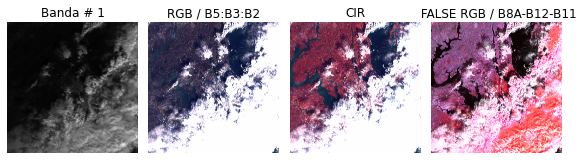

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(sentinel_cube['B01'], cmap=plt.cm.gray)
ax[0].set_title("Banda # 1")
ax[0].axis('off')
ax[1].imshow(rgb)
ax[1].set_title("RGB / B5:B3:B2")
ax[1].axis('off')
ax[2].imshow(cir)
ax[2].set_title("CIR")
ax[2].axis('off')
ax[3].imshow(dif_rgb)
ax[3].set_title(" FALSE RGB / B8A-B12-B11")
ax[3].axis('off')
fig.tight_layout()
plt.show()

In [9]:
def kernel(size=3, value=1):
    """Kernel usado para el filtro en convolución"""
    return value * np.ones((size, size))

def mse(image_one, image_two):
    """Mean Squared Error"""
    return np.sum(np.square(np.subtract(image_one, image_two))) / (image_one.shape[0] * image_two.shape[1])

In [10]:
img = sentinel_cube['B01']

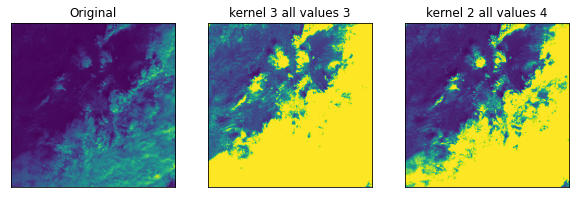

In [11]:
image_filtered_1 = cv2.filter2D(img, -1, kernel(3,3))
image_filtered_2 = cv2.filter2D(img, -1, kernel(2,4))

plt.figure(figsize=(10, 5))
plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(image_filtered_1),plt.title('kernel 3 all values 3')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(image_filtered_2),plt.title('kernel 2 all values 4')
plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
print(f"MSE entre la imagen orginal y la filtrada con una matriz 2x2 llena de 4's = {mse(img,image_filtered_2)}")

MSE entre la imagen orginal y la filtrada con una matriz 2x2 llena de 4's = 450.3492648332288


In [13]:
print(f"MSE entre la imagen orginal y la filtrada con una matriz 3x3 llena de 3's = {mse(img,image_filtered_1)}")

MSE entre la imagen orginal y la filtrada con una matriz 3x3 llena de 3's = 449.0257699543134


In [14]:
cube = np.dstack((
    sentinel_cube['B05'][2000:6000, :2000], 
    sentinel_cube['B06'][2000:6000, :2000],
    sentinel_cube['B07'][2000:6000, :2000], 
    sentinel_cube['B11'][2000:6000, :2000],
    sentinel_cube['B12'][2000:6000, :2000],
    sentinel_cube['B8A'][2000:6000, :2000]))
pca = PCA(n_components = 3)

In [15]:
w, h, c = cube.shape
# Organizamos en un arreglo de 2 D
cube_2d = cube.reshape((w * h, c))
principalComponents = pca.fit_transform(cube_2d)
final_cube = principalComponents.reshape((w, h, pca.n_components))

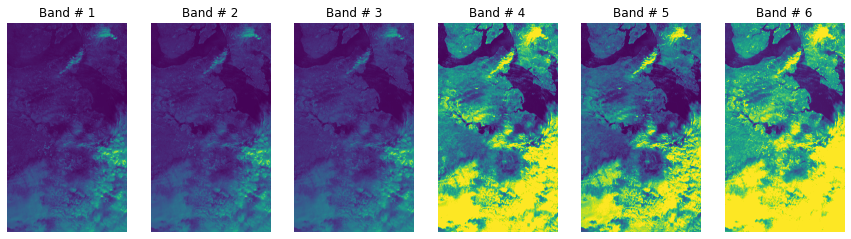

In [16]:
# Graficamos las 3 bandas
fig = plt.figure(figsize=(15, 15))

for i in range(1, 1+c):
    fig.add_subplot(1,c, i)
    plt.imshow(cube[:,:,i-1])
    plt.axis('off')
    plt.title(f'Band # {i}')

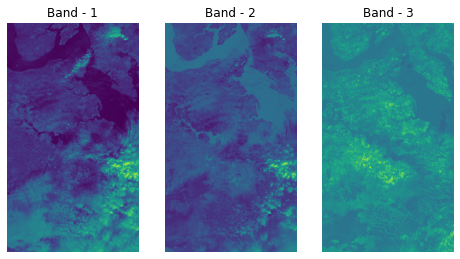

In [17]:
# Graficamos las 3 bandas
fig = plt.figure(figsize=(8, 5))
n = pca.n_components
for i in range(1, 1+n):
    fig.add_subplot(1,n, i)
    plt.imshow(final_cube[:,:,i-1])
    plt.axis('off')
    plt.title(f'Band - {i}')

In [18]:
RED = sentinel_cube['B04'][2000:6000, :2000].astype('float32')
NIR = sentinel_cube['B08'][2000:6000, :2000].astype('float32')

In [19]:
NDVI = np.where(
           np.add(NIR, RED) == 0,
           0,
           np.divide(np.subtract(NIR, RED), np.add(NIR, RED))
             )

MSR = np.where(
           np.add(NIR, RED) + 1 <= 0,
           0,
           np.divide(np.subtract(NIR, RED) - 1 , np.sqrt(np.add(NIR, RED) + 1))
             )

TVI = np.where(
           np.add(NDVI, 0.5) <= 0,
           0,
           np.sqrt(np.add(NDVI, 0.5))
             )

<ipython-input-19-5fdf2b2680bc>:16: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.add(NDVI, 0.5))


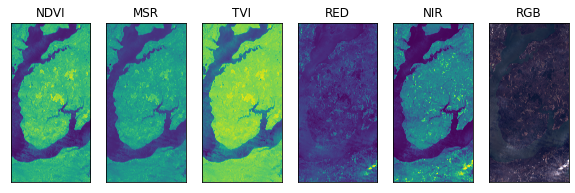

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(161),plt.imshow(NDVI),plt.title('NDVI')
plt.xticks([]), plt.yticks([])
plt.subplot(162),plt.imshow(MSR),plt.title('MSR')
plt.xticks([]), plt.yticks([])
plt.subplot(163),plt.imshow(TVI),plt.title('TVI')
plt.xticks([]), plt.yticks([])
plt.subplot(164),plt.imshow(RED),plt.title('RED')
plt.xticks([]), plt.yticks([])
plt.subplot(165),plt.imshow(NIR),plt.title('NIR')
plt.xticks([]), plt.yticks([])
plt.subplot(166),plt.imshow(rgb[2000:6000, :2000, :]),plt.title('RGB')
plt.xticks([]), plt.yticks([])
plt.show()